In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from lstm_class import MidiLSTM

In [2]:
#Allows importing from parent directory
import sys
import os
PROJECT_ROOT = r"C:\Users\rober\OneDrive\Documents\0.School\WILLIAM PERKIN\Comp\1. NEA project prototype"
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

In [4]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
#Create an instance of the model on the device
model = MidiLSTM().to(device)

Using device: cuda


In [103]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from AI_TRAINING import MIDIDatasetNPY, MidiTokenizer
from glob import glob
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np

npy_file_paths = glob(r"C:\tempp\ACCOMPANIMENT_TOKENS\*.npy")

n_files = len(npy_file_paths)
np.random.shuffle(npy_file_paths)
train_files = npy_file_paths[:n_files-2150] # Use all files except last 2150
val_files = npy_file_paths[n_files-2150:n_files-1900] # Use second last 250 files
test_files = npy_file_paths[n_files-1900:] # Use last 1900 files

train_dataset = MIDIDatasetNPY(train_files, seq_length=64, mode="train", samples_per_epoch = 500000, files_per_epoch=5000) # Will contain all files except last 2150 but only 5000 will be used per epoch
val_dataset = MIDIDatasetNPY(val_files, seq_length=64, mode = "val") # Will contain 250 files
test_dataset = MIDIDatasetNPY(test_files, seq_length=64, mode = "test") # Will contain 1900 files

# Create DataLoader for training
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=1, pin_memory=True)

# Create DataLoader for validation
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=1, pin_memory=True)

# Create DataLoader for testing
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=1, pin_memory=True)

Counting sequences (test): 100%|██████████| 1900/1900 [00:01<00:00, 1710.86it/s]


In [ ]:
# Convert the data to PyTorch tensors
#X_train, y_train = train_dataset.split_X_y()
#X_test, y_test = test_dataset.split_X_y()

In [ ]:
#print(X_train.shape)  # should be: [batch_size, seq_len]
#print(X_test.shape)   # should be: [batch_size, seq_len]
#print(y_train.shape)  # should be: [batch_size]
#print(y_test.shape)   # should be: [batch_size]

In [ ]:
# Send the data to the device (GPU or CPU) to allow for parallel processing
#X_test = X_test.to(device)
#y_test = y_test.to(device)
#X_train = X_train.to(device)
#y_train = y_train.to(device)

In [105]:
# Set the criterion of the model to measure the error
criterion = nn.CrossEntropyLoss()

# Set the optimizer to update the model parameters; Set learning rate and weight decay (to prevent overfitting)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [109]:
model.parameters
print(len(train_dataset.file_paths))

13422


In [ ]:
from tqdm import tqdm
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import csv
import os

# Training loop with debug checks
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = MidiTokenizer()
vocab_size = tokenizer.tokenizer.vocab_size

model = MidiLSTM(vocab_size=vocab_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

total_epochs = 50
batch_size = 64
losses = []
avg_losses = []

scaler = GradScaler()

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3) # Reduces the Learning Rate when validation loss plateaus

class EarlyStopping:
    def __init__(self, patience=5, delta=0.0, save_dir=None):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.save_dir = save_dir

    def __call__(self, val_loss, model, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
            self._save_checkpoint(model, epoch)
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self._save_checkpoint(model, epoch)
            self.counter = 0

    def _save_checkpoint(self, model, epoch):
        """Save best model so far (optional)."""
        if self.save_dir:
            path = os.path.join(self.save_dir, "best_model.pt")
            torch.save(model.state_dict(), path)
            print(f"Saved new best model (epoch {epoch+1}, val_loss={self.best_loss:.4f})")

early_stopper = EarlyStopping(patience=5, delta=0.01, save_dir=r"D:\ckpts_v3\best_model")

# Find latest checkpoint in save_dir
save_dir = r"D:\ckpts_v3"
checkpoints = [f for f in os.listdir(save_dir) if f.endswith(".pt")]
if checkpoints:
    latest_ckpt = max(
        checkpoints,
        key=lambda f: int(f.split("_epoch_")[1].split(".pt")[0])  # extract epoch number
    )
    ckpt_path = os.path.join(save_dir, latest_ckpt)
    print(f"Resuming from checkpoint: {ckpt_path}")

    checkpoint = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
else:
    print("No checkpoint found, starting fresh.")
    start_epoch = 0


# Setup a .csv logging file to keep track of training progess even if training gets interrupted
log_dir  = os.path.join(save_dir, ".logging")
log_path = os.path.join(log_dir, "training_log.csv")

# If the file doesn't exist, create it and write header
if not os.path.exists(log_path):
    os.makedirs(log_dir, exist_ok=True)
    with open(log_path, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "train_loss", "val_loss", "val_acc", "learning_rate"])


for epoch in range(total_epochs - start_epoch):
    epoch += start_epoch
    model.train()
    print(f"\nStarting epoch {epoch+1}/{total_epochs}...")

    train_dataset.set_epoch_files() # Shuffle files for next epoch
    
    losses = []

    # Wrap train_loader with tqdm
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{total_epochs}", unit="batches")

    for i, (batch_x, batch_y) in enumerate(progress_bar):
        # Move data to device
        x = batch_x.to(device)
        y = batch_y.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Establish learning rate
        learning_rate = optimizer.param_groups[0]["lr"]

        with autocast(device_type=device.type):

            outputs = model(x) # Forward pass

            # Compute the loss comparing all the predicted tokens(one after the other) with all the
            # Correct tokens (one after the other)
            loss = criterion(outputs.view(-1, vocab_size), y.view(-1)) 
        
        # Debug print for the very first batch only
        #if i == 0 and epoch == 0:
            #print("DEBUG SHAPES/DATATYPES:")
            #print("x:", x.shape, x.dtype, x.device)
            #print("y:", y.shape, y.dtype, y.device)
            #print("outputs:", outputs.shape, outputs.dtype, outputs.device)

        # Track loss
        losses.append(loss.item())

        # Backpropagation
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping to handle exploding gradients (when gradients become too large)
        scaler.step(optimizer)
        scaler.update()
        
    # Average loss per epoch
    avg_loss = sum(losses) / len(losses)
    avg_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{total_epochs}], Average Loss: {avg_loss:.4f}")

    
    # Validation every 2 epochs
    val_loss = ""
    val_acc = ""
    if (epoch + 1) % 2 == 0:
        print("-------------------------------") # Line for separation
        model.eval()
        val_losses = []
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_x, batch_y in tqdm(val_loader, desc="Validating: ", unit="batches"):
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs.view(-1, outputs.size(-1)), batch_y.view(-1))
                val_losses.append(loss.item())

                preds = outputs.argmax(dim=-1)
                correct += (preds == batch_y).sum().item()
                total += batch_y.numel()

        val_loss = sum(val_losses) / len(val_losses)
        val_acc = correct / total * 100
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
        scheduler.step(val_loss)
        early_stopper(val_loss, model, epoch) # Early stopping to prevent overfitting
        if early_stopper.early_stop:
            print("Early stopping triggered. Training halted.")
            break
    
    # Save model after each epoch
    os.makedirs(save_dir, exist_ok=True)

    checkpoint_path = os.path.join(save_dir, f"checkpoint_v3_epoch_{epoch+1}.pt")
    print(f"Saving to: {checkpoint_path}...")

    #Save the checkpoint
    try:
        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": avg_loss
        }, checkpoint_path)
        print("Checkpoint saved successfully.")

    except Exception as e:
        print("Save failed:", e)

    try:
        with open(log_path, mode="a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([epoch+1, avg_loss, val_loss, val_acc, learning_rate])

    except Exception as e:
        print("Logging failed:", e)

print("Training finished!")

Resuming from checkpoint: D:\ckpts_v3\checkpoint_v3_epoch_49.pt

Starting epoch 50/50...


Epoch 50/50: 100%|██████████| 7813/7813 [06:24<00:00, 20.30batches/s]


Epoch [50/50], Average Loss: 1.3812
-------------------------------


Validating: 100%|██████████| 18016/18016 [05:11<00:00, 57.90batches/s]

Validation Loss: 1.3726, Accuracy: 59.55%
Saved new best model (epoch 50, val_loss=1.3726)
Saving to: D:\ckpts_v3\checkpoint_v3_epoch_50.pt...
Checkpoint saved successfully.
Training finished!


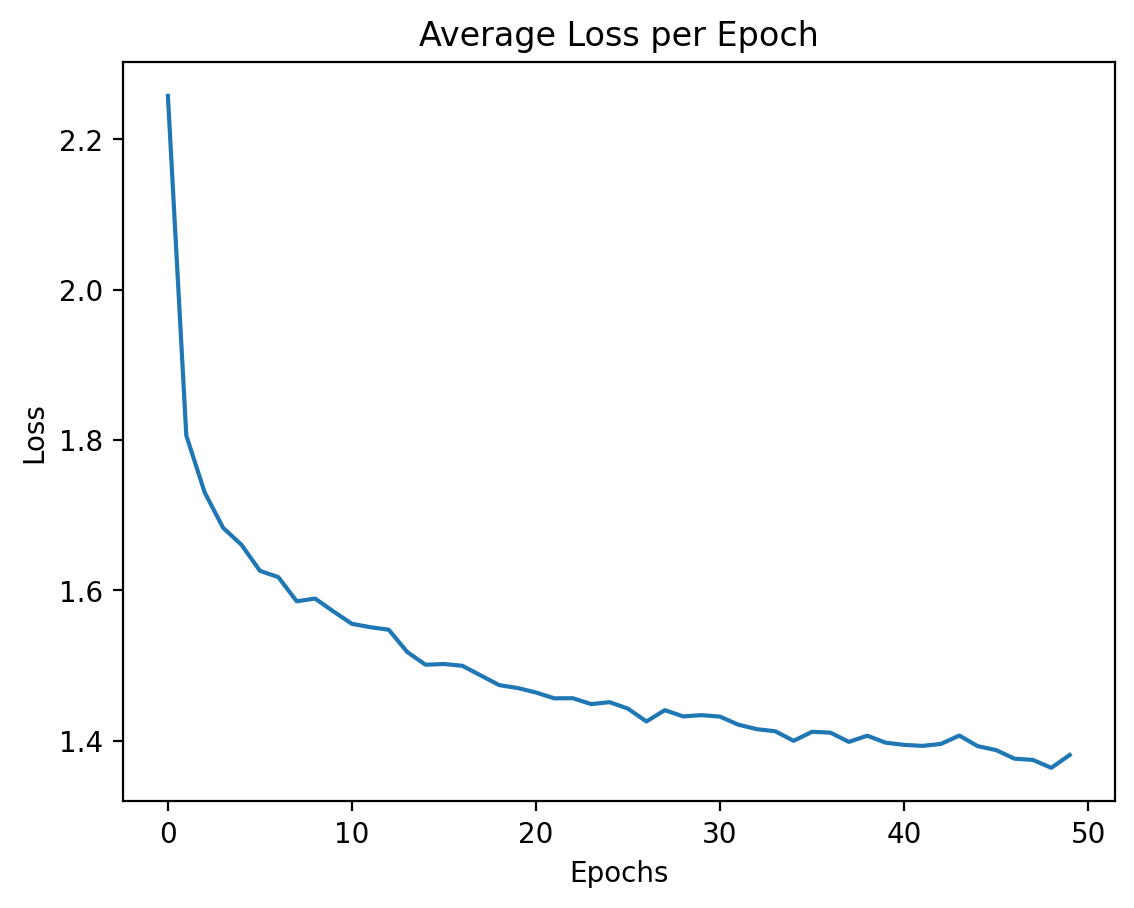

In [142]:
import matplotlib.pyplot as plt
import pandas as pd

logging_dir = "D:/ckpts_v3/.logging"

epoch_range = range(total_epochs)
plt.title('Average Loss per Epoch')

columns = ["epoch", "train_loss", "val_loss", "val_acc", "learning_rate"]
df = pd.read_csv(f"{logging_dir}/training_log.csv", usecols=columns)
df_val = df.dropna()  # Remove rows with NaN values (in case some epochs didn't have validation)
#print("Contents in csv file:", df)

plt.plot(epoch_range, df.train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

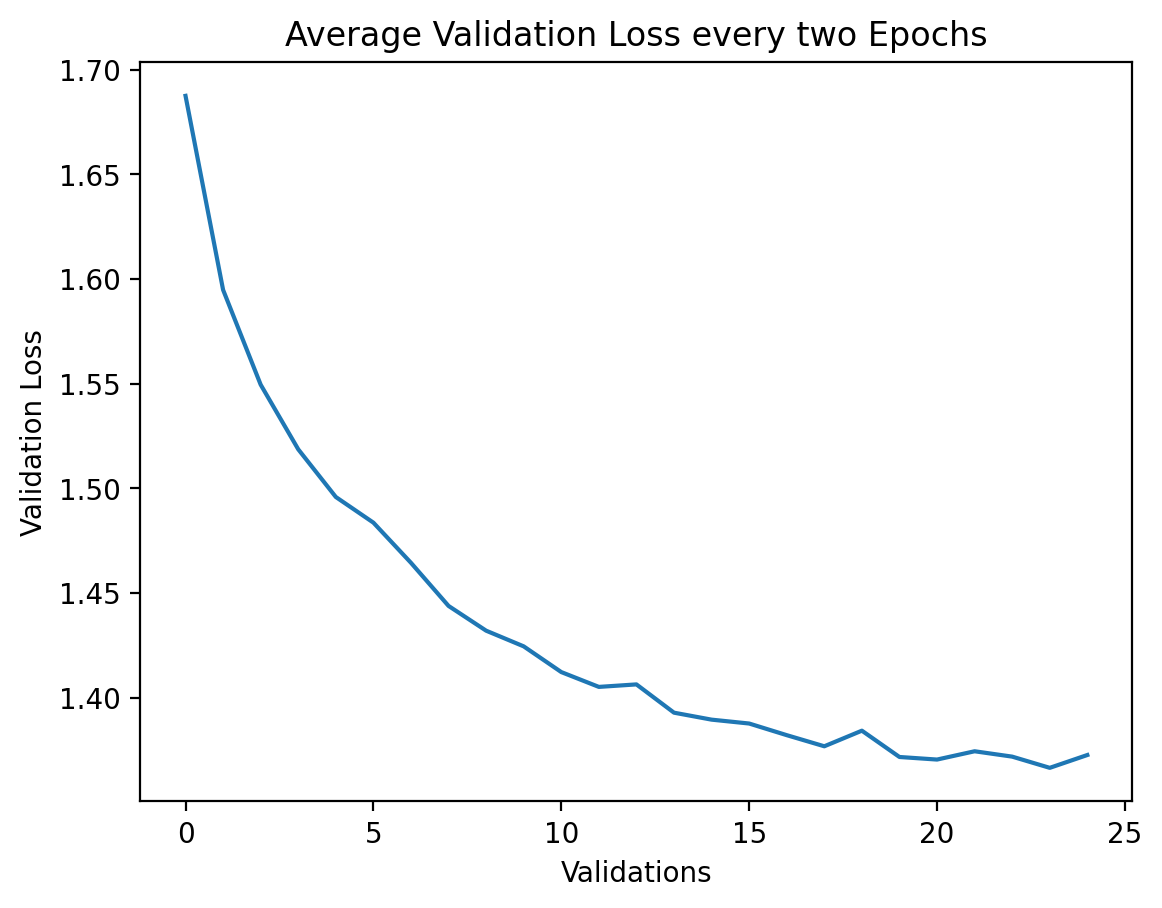

In [143]:
val_range = range(total_epochs//2)
plt.title('Average Validation Loss every two Epochs')
plt.plot(val_range, df_val.val_loss)
plt.xlabel('Validations')
plt.ylabel('Validation Loss')
plt.show()

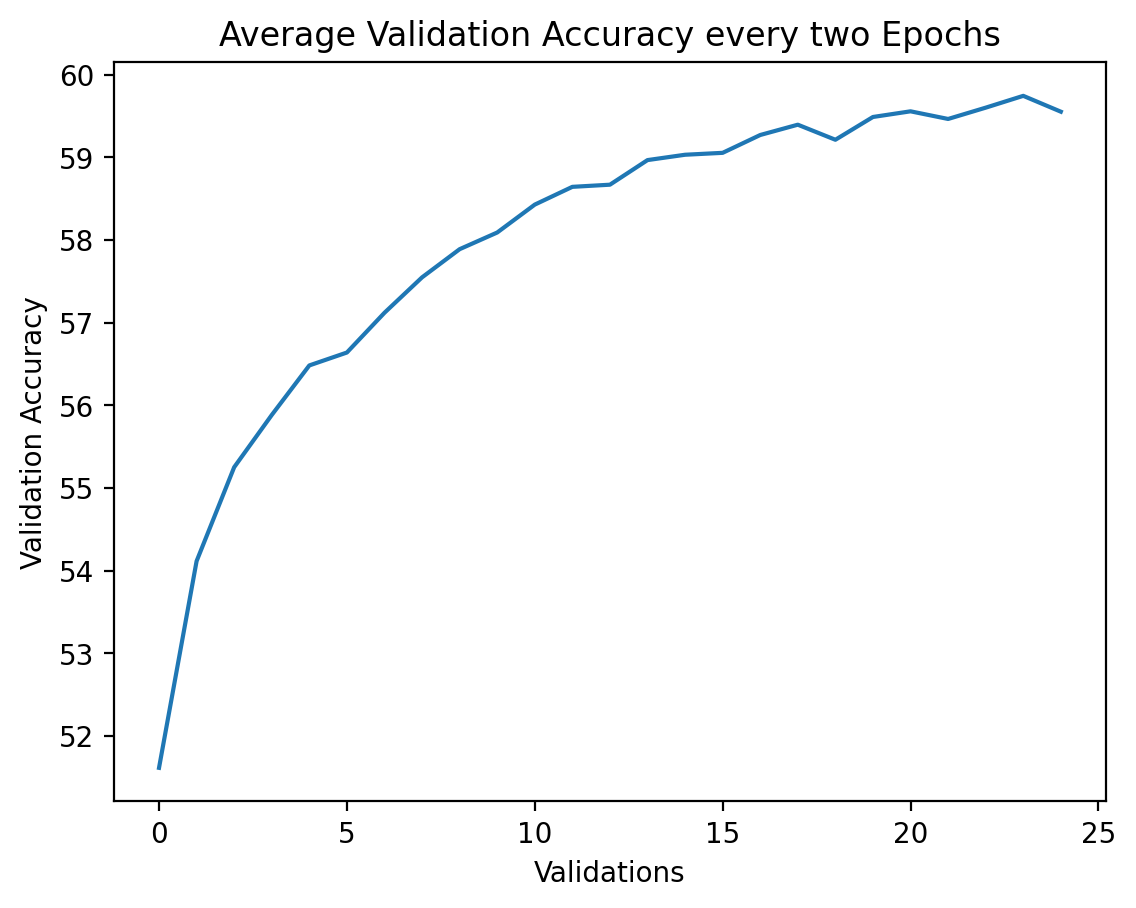

In [144]:
val_range = range(total_epochs//2)
plt.title('Average Validation Accuracy every two Epochs')
plt.plot(val_range, df_val.val_acc)
plt.xlabel('Validations')
plt.ylabel('Validation Accuracy')
plt.show()

In [147]:
new_model = MidiLSTM(vocab_size=vocab_size)
model_path = (torch.load(r'D:\ckpts_v3\best_model\best_model.pt'))
new_model.load_state_dict(model_path)

new_model.to(device)

new_model.eval()

MidiLSTM(
  (embedding): Embedding(328, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=512, out_features=328, bias=True)
)

In [148]:
from tqdm import tqdm

correct = 0
total = 0
total_loss = 0

with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader, desc="Evaluating", unit="samples"):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        outputs = new_model(x_batch)  # Forward pass for each sample

        # Compute loss for evaluation
        loss = criterion(outputs.view(-1, vocab_size), y_batch.view(-1))
        total_loss += loss.item() * x_batch.size(0) # Multiply loss by batch size so that the loss in independent of batch size

        # Get the predicted tokens
        preds = outputs.argmax(dim = -1)

        # Compare predictions with actual tokens
        correct += (preds == y_batch).sum().item() # Gets the number of correct predictions by comparing tokens
        total += y_batch.numel() #numel() return the number of elements in the tensor

avg_loss = total_loss / len(test_dataset)
accuracy = (correct / total) * 100

print(f'Validation Loss: {avg_loss:.4f}')
print(f'Accuracy: {accuracy:.2f}%')
print(f'Total correct predictions: {correct} out of {total}')

Evaluating: 100%|██████████| 141292/141292 [39:44<00:00, 59.25samples/s]

Validation Loss: 1.4251
Accuracy: 58.22%
Total correct predictions: 336962247 out of 578728832


In [149]:
from tqdm import tqdm

correct = 0
total = 0
total_loss = 0

with torch.no_grad():
    for x_batch, y_batch in tqdm(train_loader, desc="Evaluating", unit="samples"):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        outputs = new_model(x_batch)  # Forward pass for each sample

        # Compute loss for evaluation
        loss = criterion(outputs.view(-1, vocab_size), y_batch.view(-1))
        total_loss += loss.item() * x_batch.size(0) # Multiply loss by batch size so that the loss in independent of batch size

        # Get the predicted tokens
        preds = outputs.argmax(dim = -1)

        # Compare predictions with actual tokens
        correct += (preds == y_batch).sum().item() # Gets the number of correct predictions by comparing tokens
        total += y_batch.numel() #numel() return the number of elements in the tensor

avg_loss = total_loss / len(train_dataset)
accuracy = (correct / total) * 100

print(f'Validation Loss: {avg_loss:.4f}')
print(f'Accuracy: {accuracy:.2f}%')
print(f'Total correct predictions: {correct} out of {total}')

Evaluating:   3%|▎         | 224/7813 [00:15<08:50, 14.31samples/s] 


KeyboardInterrupt: 

In [150]:
tokenizer = MidiTokenizer()
vocab_size = tokenizer.tokenizer.vocab_size

tokens = tokenizer.tokenize_midi_file(r"C:\Users\rober\OneDrive\Documents\0.School\WILLIAM PERKIN\Comp\1. NEA project prototype\MIDI_DATASET_MELODY\2_Hearts_melody.mid")
for i in range(len(tokens)): 
    token_ids = tokens[i].ids if isinstance(tokens, list) else tokens.ids #Ensure that tokens is a list

new_seq = token_ids[:30] # Start with the original sequence
print(f'Token IDs: {token_ids[:20]}')
print(len(token_ids))
new_seq_tensor = torch.tensor(token_ids, dtype=torch.long).unsqueeze(0).to(device)  # Convert to tensor and add batch dimension

Token IDs: [297, 191, 48, 115, 125, 296, 193, 51, 115, 150, 297, 189, 46, 117, 126, 191, 48, 114, 125, 296]
2144


In [ ]:
from tqdm import tqdm
import torch
import torch.nn.functional as F

seq_length = 64
generated_tokens = new_seq.copy() # Start with the original sequence

top_k = 25 # Keep only the top_k predictions to introduce randomness
temperature = 1.0 # Controls the randomness of the predictions, the higher the value, the more random
ngram_size = 4 # Size of n-grams to avoid repetition
ngram_penalty = 1e9 # Penalty to penalize repeated n-grams

def get_recent_ngrams(tokens, n):
    ngrams = {}
    for i in range(len(tokens) - n + 1):
        g = tuple(tokens[i:i+n])
        ngrams[g] = ngrams.get(g, 0) + 1
    return ngrams

with torch.no_grad():
    for i in tqdm(range(500), desc="Predicting:", unit="predictions"):
        logits = new_model(torch.tensor(generated_tokens[-seq_length:], dtype=torch.long).unsqueeze(0).to(device))
        logits = logits[0, -1]  # Get the logits for the last time step
        
        # Apply n-gram penalty
        if len(generated_tokens) >= ngram_size:
            recent_ngrams = get_recent_ngrams(generated_tokens, ngram_size)
            for token_id in range(len(logits)):
                ngram = tuple(generated_tokens[-(ngram_size-1):] + [token_id])
                if ngram in recent_ngrams:
                    logits[token_id] -= ngram_penalty  # Reduce the probability of repeated n-grams

        # Apply temperature
        logits = logits / temperature

        # Apply top-k filtering
        topk_values, topk_indices = torch.topk(logits, top_k,)
        filtered_logits = torch.full_like(logits, float('-inf')) # Masks out all logits that we do not want
        filtered_logits[topk_indices] = logits[topk_indices]

        # Convert to probablities and sample them
        probs = F.softmax(filtered_logits, dim=-1)
        next_token = torch.multinomial(probs, 1).item() # Stochastic sampling to predict one token from the probability distribution of the top_k tokens
        
        generated_tokens.append(next_token)


print(f"Generated sequence length: {len(generated_tokens)}")
print("Generated token IDs:", generated_tokens)

Predicting:: 100%|██████████| 500/500 [00:02<00:00, 172.18predictions/s]

Generated sequence length: 530
Generated token IDs: [297, 191, 48, 115, 125, 296, 193, 51, 115, 150, 297, 189, 46, 117, 126, 191, 48, 114, 125, 296, 193, 51, 115, 151, 296, 189, 46, 117, 126, 191, 43, 115, 126, 193, 43, 115, 126, 195, 46, 116, 126, 197, 48, 117, 126, 199, 48, 115, 142, 306, 191, 44, 117, 130, 197, 44, 119, 126, 199, 44, 117, 125, 296, 201, 43, 115, 128, 205, 41, 118, 126, 207, 44, 119, 138, 297, 191, 43, 117, 126, 193, 46, 116, 126, 195, 44, 117, 126, 197, 46, 119, 128, 201, 47, 115, 126, 203, 48, 119, 126, 297, 207, 51, 119, 127, 296, 211, 51, 118, 126, 213, 53, 117, 126, 215, 51, 117, 127, 296, 219, 52, 120, 128, 4, 191, 49, 118, 126, 193, 47, 118, 126, 195, 46, 117, 126, 197, 41, 118, 126, 199, 39, 118, 126, 201, 37, 119, 126, 203, 36, 120, 127, 205, 35, 117, 126, 207, 36, 117, 127, 209, 36, 117, 127, 211, 38, 117, 127, 296, 215, 39, 119, 133, 296, 193, 36, 116, 128, 197, 38, 118, 125, 296, 199, 39, 118, 139, 298, 217, 41, 123, 126, 219, 50, 119, 126, 4, 189, 51, 12

In [157]:
from miditok import REMI, TokenizerConfig, TokSequence
from pathlib import Path
from music21 import stream, converter, midi
import os
from typing import cast
from AI_TRAINING import MidiTokenizer

tokenizer = MidiTokenizer()
#token_str = tokenizer.tokenizer._ids_to_tokens(generated_tokens)

tokens = tokenizer.tokenize_midi_file(r"C:\Users\rober\OneDrive\Documents\0.School\WILLIAM PERKIN\Comp\1. NEA project prototype\jazz_improv.mid")
midi_paths = []
full_sequence = []
for i in range(len(tokens)): 
    #token_ids = tokens[i].ids if isinstance(tokens, list) else tokens.ids #Ensure that tokens is a list
    token_ids = generated_tokens # Use the generated sequence for decoding
    print(f"Token IDs: {token_ids[:10]}...")

    #Convert token IDs back into tokens (strings)
    token_str = tokenizer.tokenizer._ids_to_tokens(token_ids)

    #print(f"{token_str[:20]}...")

    #Create a Toksequence from the tokens
    token_seq = TokSequence(
        ids=token_ids,
        tokens=cast(list[str | list[str]], token_str)  # avoid Pylance complaints
    )
    print(type(token_seq[0]))
    print(token_seq.ids[:5])  # Preview of token IDs
    print(token_seq.tokens[:5])  # Preview of token strings

    #Decode into Score
    score = tokenizer.tokenizer.decode([token_seq])

    #Export the decoded MIDI
    output_file = f"decoded_midi{i}.mid"
    score.dump_midi(Path(output_file))
    print(f"MIDI saved as {output_file}")
    midi_paths.append(output_file)
tokenizer.merge_midi_paths(midi_paths, output_path="C:/Users/rober/OneDrive/Documents/0.School/WILLIAM PERKIN/Comp/1. NEA project prototype/decoded_midi_full.mid")

Token IDs: [297, 191, 48, 115, 125, 296, 193, 51, 115, 150]...
<class 'int'>
[297, 191, 48, 115, 125]
['Rest_0.2.8', 'Position_2', 'Pitch_64', 'Velocity_91', 'Duration_0.1.8']
MIDI saved as decoded_midi0.mid
Token IDs: [297, 191, 48, 115, 125, 296, 193, 51, 115, 150]...
<class 'int'>
[297, 191, 48, 115, 125]
['Rest_0.2.8', 'Position_2', 'Pitch_64', 'Velocity_91', 'Duration_0.1.8']
MIDI saved as decoded_midi1.mid


'C:/Users/rober/OneDrive/Documents/0.School/WILLIAM PERKIN/Comp/1. NEA project prototype/decoded_midi_full.mid'